In [ ]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c superai5-air-pollution-prediction
!unzip /content/superai5-air-pollution-prediction.zip -d air-pollution

  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 26.6MB/s]
Archive:  /content/superai5-air-pollution-prediction.zip
  inflating: air-pollution/X_train.csv  
  inflating: air-pollution/sample_submission.csv  
  inflating: air-pollution/submission.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1 record = 1 hrs

In [ ]:
train_df = pd.read_csv('air-pollution/X_train.csv')
train_df

,time(day-hour),PM2.5
0,0 days 00:00:00,39.758333
1,0 days 01:00:00,46.341667
2,0 days 02:00:00,38.483333
3,0 days 03:00:00,30.100000
4,0 days 04:00:00,22.900000
...,...,...
4156,307 days 15:00:00,9.425000
4157,307 days 16:00:00,9.541667
4158,307 days 17:00:00,9.141667
4159,307 days 18:00:00,10.908333


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time(day-hour)  4161 non-null   object 
 1   PM2.5           4161 non-null   float64
dtypes: float64(1), object(1)
memory usage: 65.1+ KB


## Preprocessing

In [ ]:
def string_to_datetime(time_str):
  try:
    # Extract days, hours, minutes, and seconds
    parts = time_str.split()
    days = int(parts[0])
    hours, minutes, seconds = map(int, parts[2].split(':'))

    # Create a timedelta object
    delta = pd.to_timedelta(f'{days} days {hours} hours {minutes} minutes {seconds} seconds')

    datetime64_obj = np.datetime64('2023-08-08') + delta

    return pd.Timestamp(datetime64_obj)
  except ValueError:
    print(f"Invalid time string format: {time_str}")
    return np.nan

In [ ]:
auto_df = train_df.copy()
auto_df['time(day-hour)'] = auto_df['time(day-hour)'].apply(string_to_datetime)
auto_df.rename(columns={'PM2.5': 'target', 'time(day-hour)': 'timestamp'}, inplace=True)
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4161 non-null   datetime64[ns]
 1   target     4161 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 65.1 KB


## EDA

(308, 2)


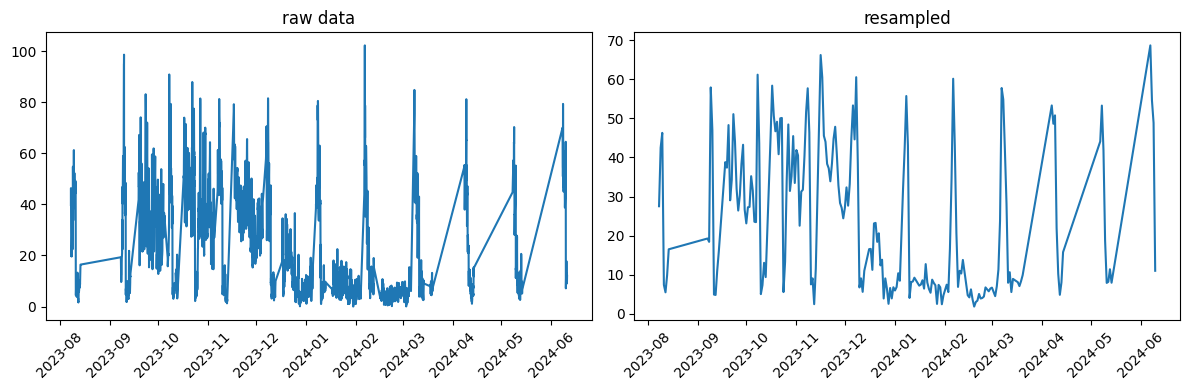

In [ ]:
auto_df = auto_df.set_index('timestamp').resample('d').mean().interpolate().reset_index()
print(auto_df.shape)

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_df['time(day-hour)'].apply(string_to_datetime), train_df['PM2.5'])
plt.xticks(rotation=45)
plt.title('raw data')

plt.subplot(1, 2, 2)
plt.plot(auto_df['timestamp'], auto_df['target'])
plt.title('resampled')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
auto_df[auto_df['timestamp'] == '2024-03-15']

,timestamp,target
220,2024-03-15,8.620404


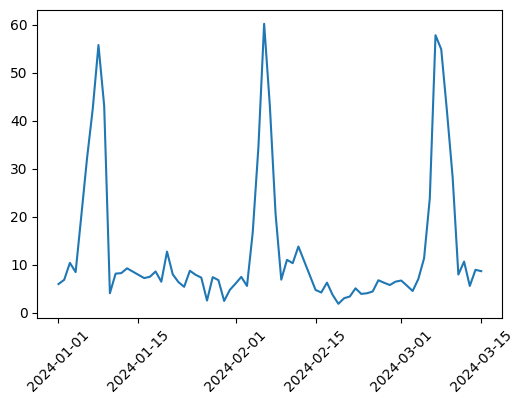

In [ ]:
train_prep = auto_df.loc[146:220].copy()
steps_left = 7388 - train_prep.index.max() - 1
train_prep.set_index('timestamp', inplace=True)

plt.figure(figsize=(6, 4))
plt.plot(train_prep['target'])
plt.xticks(rotation=45)
plt.show()

**Seasonal pattern exploration**

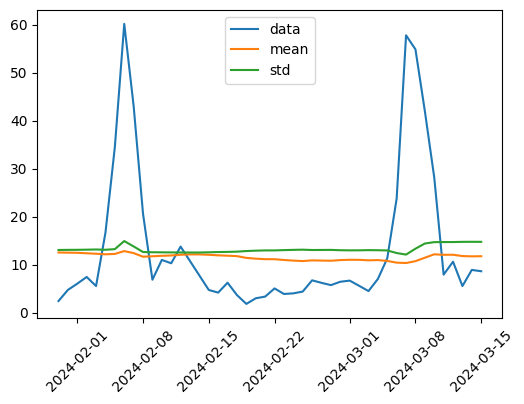

In [ ]:
def plot_stationary(data, lags=None):
    df = data.copy()
    df[f'diff'] = df['target']
    df['mean_diff'] = df[f'diff'].rolling(window=lags).mean()
    df['std_diff'] = df[f'diff'].rolling(window=lags).std()
    df.dropna(inplace=True)

    plt.figure(figsize=(6, 4))

    plt.plot(df['diff'], label='data')
    plt.plot(df['mean_diff'], label='mean')
    plt.plot(df['std_diff'], label='std')
    plt.xticks(rotation=45)
    plt.legend()

plot_stationary(train_prep, 30)

arima_order = (1, 1, 0)

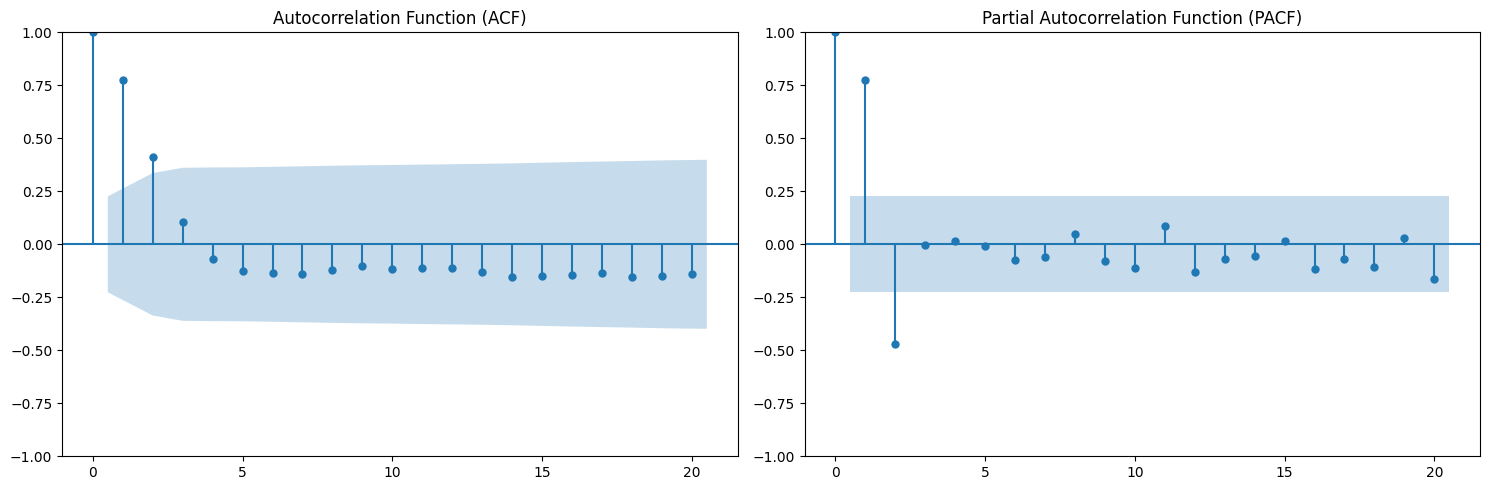

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train_prep['target'], lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(train_prep['target'], lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

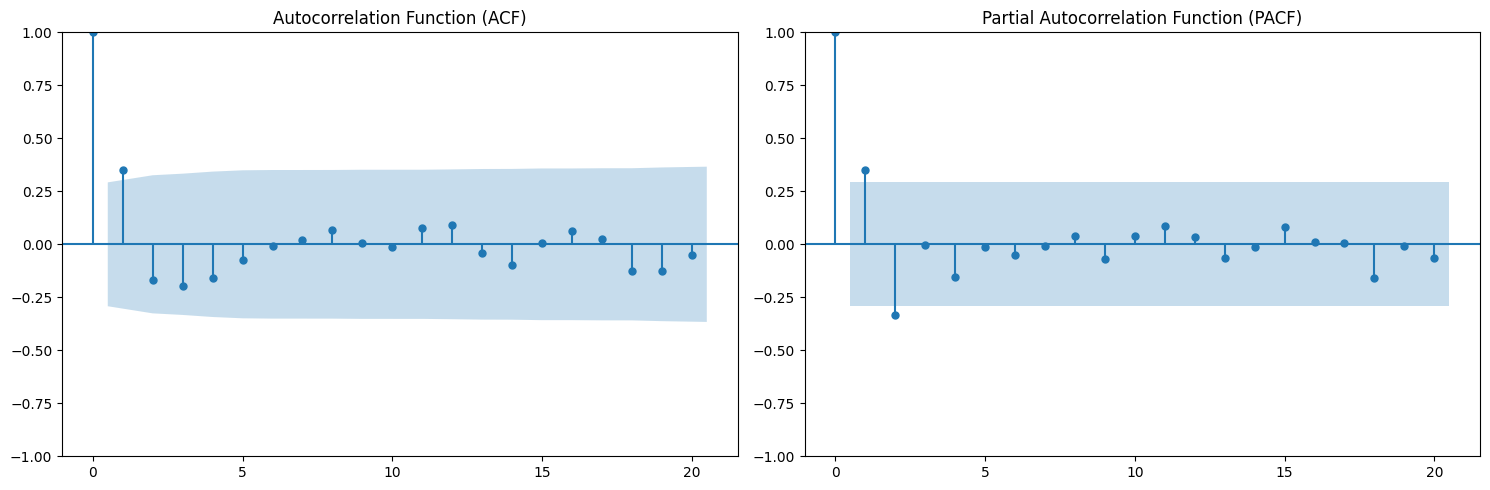

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train_prep['target'].diff(30).dropna(), lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(train_prep['target'].diff(30).dropna(), lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Deep Learning Approach

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, Conv1D, MaxPooling1D, Dropout
from tqdm import tqdm

In [ ]:
# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Adjust sequence length as needed
X, y = create_sequences(train_prep['target'].values, seq_length)

# Reshape the input data for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(44, 30, 1)

In [ ]:
model = Sequential(name='Bi-LSTM')
model.add(Input(shape=(seq_length, X.shape[2])))

model.add( Conv1D(filters=32, kernel_size=3, activation='relu') )
model.add( MaxPooling1D(pool_size=2) )
model.add( Dropout(0.5))

# LSTM for sequence learning
model.add( Bidirectional(LSTM(64, return_sequences=True)) )
model.add(Dropout(0.5))
model.add( Bidirectional(LSTM(32, return_sequences=False)) )
model.add(Dropout(0.5))

# Fully Connected Layers
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(metrics=['r2_score'], optimizer='adam', loss='mse')
model.summary()

Model: "Bi-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 28, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_34 (Bidirectional)     │ (None, 14, 128)             │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,121 (363.75 KB)

 Trainable params: 93,121 (363.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X, y, validation_split=0.2,
          epochs=200, batch_size=1024, verbose=True)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 243.7827 - r2_score: -0.7081 - val_loss: 1046.7642 - val_r2_score: -1.7877
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 241.7102 - r2_score: -0.6936 - val_loss: 1029.1183 - val_r2_score: -1.7408
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 235.8329 - r2_score: -0.6524 - val_loss: 1014.0100 - val_r2_score: -1.7005
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 230.7066 - r2_score: -0.6165 - val_loss: 999.6441 - val_r2_score: -1.6623
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 221.6591 - r2_score: -0.5531 - val_loss: 985.1833 - val_r2_score: -1.6237
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 221.6249 - r2_score: -0.5528 - val_loss: 971.2701 - val_r2_score: -1.5867
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 219.6805 - r2_score: -0.5392 - val_loss: 957.6487 - val_r2_score: -1.5504
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 212.6789 -

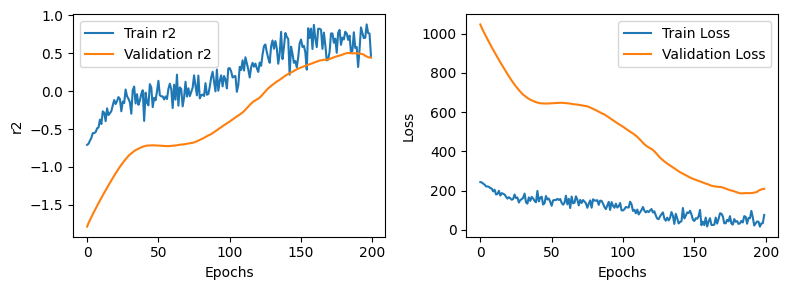

In [ ]:
def plot_summary(history):
    metrics = history.history
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['r2_score'], label='Train r2')
    plt.plot(metrics['val_r2_score'], label='Validation r2')
    plt.xlabel('Epochs')
    plt.ylabel('r2')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_summary(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


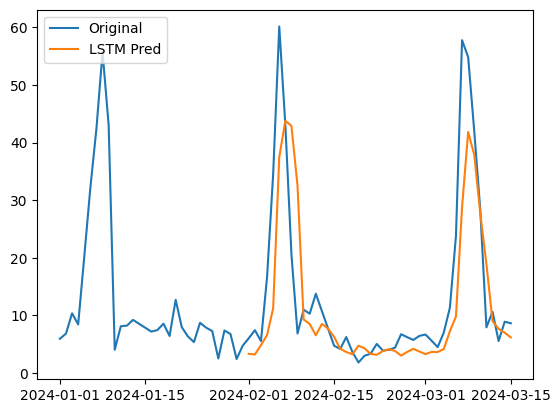

In [ ]:
y_pred = model.predict(X)
plt.plot(train_prep.index, train_prep['target'].values, label='Original')
plt.plot(train_prep.index[31:], y_pred[:, 0], label='LSTM Pred')
plt.legend()
plt.show()

**Prediction**
- end of train set: 307 days 19:00:00
- end of submission: 340 days 23:00:00

In [ ]:
# Generate forecast for 220 time steps
forecast_steps = 34
forecasts = []
last_seq = train_prep['target'].values[-seq_length:].reshape(1, seq_length, 1)
input_seq = last_seq.copy()

for _ in tqdm(range(forecast_steps)):
    forecast = model.predict(input_seq, verbose=False)
    forecasts.append(forecast[0, 0])

    # Update the input sequence for the next prediction
    input_seq = np.concatenate((input_seq[:, 1:, :], forecast.reshape(1, 1, 1)), axis=1)

100%|██████████| 34/34 [00:03<00:00, 10.12it/s]


In [ ]:
last_timestamp = train_prep.index[-1]
forecast_dates = pd.date_range(start=last_timestamp + pd.Timedelta(days=1), periods=forecast_steps)

forecast_df = pd.DataFrame({'timestamp': forecast_dates, 'forecast': forecasts})
forecast_df = forecast_df.set_index('timestamp')

forecast_df.head()

,forecast
timestamp,
2024-03-16,5.406276
2024-03-17,4.614450
2024-03-18,3.807078
2024-03-19,3.397534
2024-03-20,3.257326


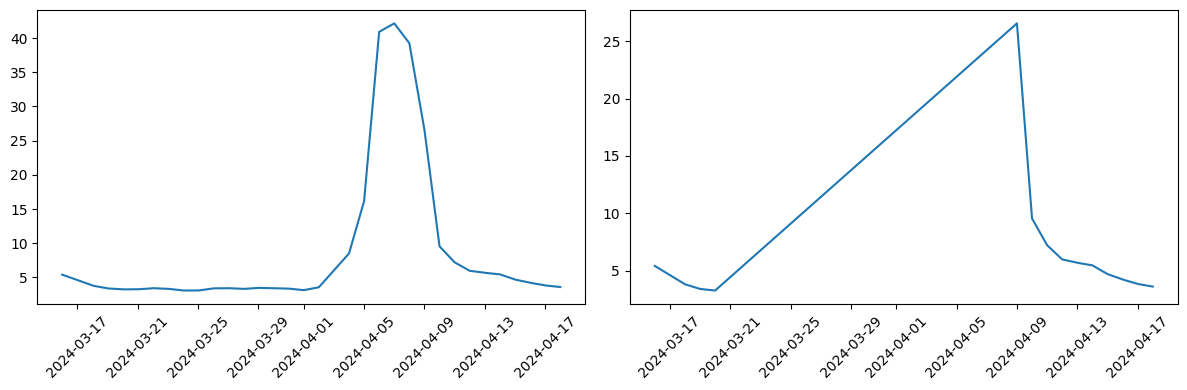

In [ ]:
forecasts = forecast_df.resample('h').mean().interpolate()

chunk_1 = forecasts[:forecast_df.index[0] + pd.Timedelta(days=4)]
chunk_2 = forecasts[forecast_df.index[0] + pd.Timedelta(days=24):]
submit = pd.concat([chunk_1, chunk_2])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(forecasts)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(submit)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Submission
- lags of submission timestaps same as training
- วัน 310 แล้วโดดไป 331 เลย

In [ ]:
submission = pd.read_csv('/content/air-pollution/sample_submission.csv')
submission['PM2.5'] = submit[len(submit)-220:].values
submission

,time(day-hour),PM2.5
0,307 days 20:00:00,3.269010
1,307 days 21:00:00,3.263168
2,307 days 22:00:00,3.257326
3,307 days 23:00:00,26.569914
4,308 days 00:00:00,25.860649
...,...,...
215,340 days 19:00:00,3.640848
216,340 days 20:00:00,3.631262
217,340 days 21:00:00,3.621677
218,340 days 22:00:00,3.612092


In [ ]:
submission.to_csv('weird_chunk.csv', index=False)